## Week4 Vision


### 문제 1

1-stage-detector와 2-stage-detector의 차이를 설명해주세요.


답 : 1-stage는 객체의 위치와 클래스를 동시에 예측하는 것. 2-stage는 객체 후보 영역을 먼저 생성하고, 그 영역에서 정확한 바운딩 박스와 클래스를 예측하는 2단계를 거치는 방법.

### 문제 2
IoU(Intersection over Union) 기반 객체 탐지 평가

아래 코드의 빈칸을 완성시켜 실행해주세요.

In [1]:
def calculate_iou(box1, box2):
    """
    두 개의 바운딩 박스를 입력받아 IoU(Intersection over Union)를 계산하는 함수
    box1, box2는 (x1, y1, x2, y2) 형식
    """
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    # 교차 영역 (Intersection) 계산
    xi1, yi1 = max(x1, x1g), max(y1, y1g)  # 교차 영역의 왼쪽 상단
    xi2, yi2 = min(x2, x2g), min(y2, y2g)  # 교차 영역의 오른쪽 하단
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)  # 교차 영역의 넓이

    # 각 바운딩 박스의 면적 계산
    box1_area = (x2 - x1) * (y2 - y1)  # box1의 면적
    box2_area = (x2g - x1g) * (y2g - y1g)  # box2의 면적
    union_area = box1_area + box2_area - inter_area  # 합집합 면적

    # IoU 계산
    return inter_area / union_area if union_area > 0 else 0

# 테스트 바운딩 박스
box_pred = [50, 50, 150, 150]  # 예측 박스
box_true = [60, 60, 140, 140]  # 실제 정답 박스

# IoU 계산
iou = calculate_iou(box_pred, box_true)
print(f"IoU: {iou:.4f}")

# IoU 임계값(0.5) 기준으로 TP/FP 판별
threshold = 0.5
if iou >= threshold:
    print("탑지 성공 (True Positive)")
else:
    print("탑지 실패 (False Positive)")

IoU: 0.6400
탑지 성공 (True Positive)


### 문제 3
Hugging Face에서 모델을 불러와 yolov8을 사용해보는 과제입니다.

아래 코드의 빈칸을 완성시켜 실행해주세요.

런타임을 T4로 바꾸고 실행해주세요!!

In [2]:
pip install -q ultralytics transformers torch torchvision opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


YOLOv8 model loaded on cpu

0: 384x640 2 persons, 154.2ms
Speed: 6.0ms preprocess, 154.2ms inference, 9.5ms postprocess per image at shape (1, 3, 384, 640)


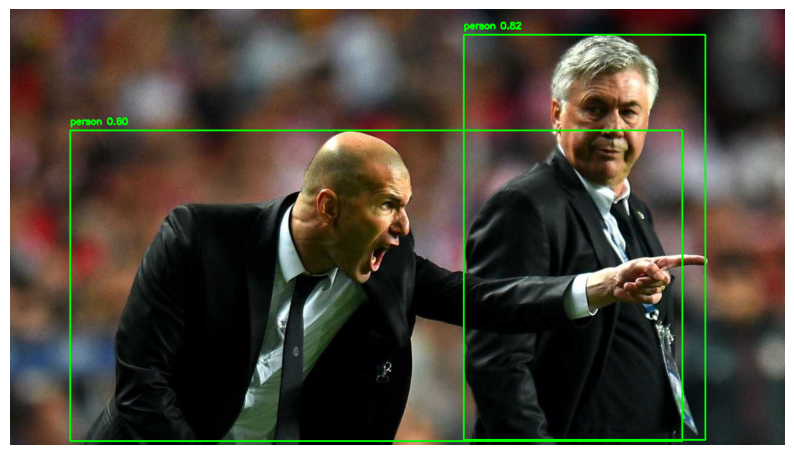

In [5]:
import torch
import cv2
import requests
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
from huggingface_hub import hf_hub_download

# CUDA 사용 여부 확인
device = "cuda" if torch.cuda.is_available() else "cpu"

# Hugging Face에서 YOLOv8 모델 다운로드
model_repo = "ultralytics/yolov8"
model_filename = "yolov8n.pt"

# 모델을 Hugging Face Hub에서 다운로드하여 저장
model_path = hf_hub_download(repo_id=model_repo, filename=model_filename)

# YOLOv8 모델 로드
model = YOLO(model_path).to(device)
print(f"YOLOv8 model loaded on {device}")

# 테스트 이미지 다운로드
image_path = "test.jpg"
image_url = "https://ultralytics.com/images/zidane.jpg"

if not os.path.exists(image_path):
    print("Downloading test image...")
    response = requests.get(image_url, stream=True)
    if response.status_code == 200:
        with open(image_path, "wb") as file:
            file.write(response.content)
        print("Test image downloaded successfully!")
    else:
        raise Exception("Failed to download test image.")

# 이미지 로드 및 변환
image = cv2.imread('test.jpg')  # 이미지 파일 경로 지정
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR을 사용하므로 RGB로 변환

# YOLOv8 객체 탐지 수행
results = model(image_rgb)  # 모델에 이미지 전달하여 객체 탐지 수행

# 탐지 결과 시각화
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # 바운딩 박스 좌표
        conf = box.conf[0]  # 신뢰도
        cls = int(box.cls[0])  # 클래스 인덱스

        # 클래스 이름 가져오기
        class_name = model.names[cls]

        # 바운딩 박스 그리기
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image_rgb, f"{class_name} {conf:.2f}", (x1, y1 - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# 결과 출력
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()